### Vanilla Policy Gradient (VPG) Agent

Vanilla Policy Gradient (VPG) is a reinforcement learning algorithm that optimizes a policy by directly maximizing the expected return:

```math
J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} [R(\tau)]
```

Here, $\tau$ denotes a trajectory and $R(\tau)$ is the return along the trajectory $\tau$.

To find the optimal policy parameters, we compute the gradient of $J(\theta)$ with respect to $\theta$.  
This gradient is

```math
\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} [\nabla_\theta R(\tau)]
```

Using the log-likelihood trick, we can rewrite the gradient as

```math
\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[\sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot R_t\right]
```

Thus, the gradient contribution from a single trajectory is

```math
\sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot R_t
```

In the following implementation, this is seen in `Agent.learn`:

```python
for log_prob, R_t in zip(log_probs, returns):
    loss.append((-log_prob * R))
L = torch.cat(loss).sum()

```

Directly afterwards, the policy is trained to maximize returns via gradient descent:

```python
self.optimizer.zero_grad()
L.backward()
self.optimizer.step()
```


In practice, trajectories $\tau$ are sampled using monte carlo methods which involve sampling and averaging multiple trajectories of the policy:

```python
n_trajectories = 800
for i in range(n_trajectories + 1):

    . . .

    T = 1000
    for t in range(1, T+1):

    . . .

```

---

The full implementation of the algorithm is below.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PolicyNetwork(nn.Module):
    """ A Parameterized Policy Network π_θ:
     
        A feedforward neural network that represents a parameterized policy. 
        It maps observations to a probability distribution over a discrete action space.

        Args:
            n_obs_dim (int): The dimensionality of the observation space.
            n_action_dim (int): The dimensionality of the action space.
            n_hidden_dim (int, optional): The number of nodes in the hidden layer. Default is 128.

    """
    
    def __init__(self, n_obs_dim: int, n_action_dim: int, n_hidden_dim=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(n_obs_dim, n_hidden_dim)
        self.fc2 = nn.Linear(n_hidden_dim, n_action_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [2]:
from torch.distributions import Categorical
import numpy as np

class Agent:
    """ A Vanilla Policy Gradient (VPG) Agent: 

        Args:
            n_obs_dim (int): The dimensionality of the observation space.
            n_action_dim (int): The dimensionality of the action space.
            alpha (float, optional): Learning Rate. Default is 1e-3.
            gamma (float, optional): Discount Factor. Default is 0.99.
            entropy_regularization_coefficient (float, optional): Entropy Regularization Coefficient. Default is 0.5.
            gradient_clipping_coefficient (float, optional): Gradient Clipping Coefficient. Default is 0.5.

        Attributes:
            alpha (float): Learning Rate.
            gamma (float): Discount Factor.
            entropy_regularization_coefficient (float): Entropy Regularization Coefficient.
            gradient_clipping_coefficient (float): Gradient Clipping Coefficient.
            policy (PolicyNetwork): Parameterized Policy Network π_θ.
            optimizer (torch.optim.Optimizer): Optimizer.
            eps (float): Machine Epsilon.

    
        Methods:

            act(state: np.ndarray) -> tuple[int, torch.Tensor]:
                Samples an action for the given state using the current parameterized policy π_θ.

            learn(self, rewards: list[float], log_probs: list[torch.Tensor], entropies: list[torch.Tensor]) -> float:
                Perform a policy update using the policy gradient method.
    
    """

    def __init__(self, obs_space: int, act_space: int, alpha=1e-3, gamma=0.99, entropy_regularization_coefficient=0.05, gradient_clipping_coefficient=0.5):

        # set hyperparameters
        self.alpha = alpha      # learning rate
        self.gamma = gamma      # discount factor

        # for entropy regularization
        self.entropy_regularization_coefficient = entropy_regularization_coefficient

        # for gradient clipping
        self.gradient_clipping_coefficient = gradient_clipping_coefficient

        self.policy = PolicyNetwork(obs_space, act_space)
        self.optimizer = torch.optim.AdamW(self.policy.parameters(), lr=self.alpha)

        self.eps = np.finfo(np.float32).eps.item() # utility: machine epsilon

    def act(self, state: np.ndarray) -> tuple[int, torch.Tensor]:
        """
            Samples an action for the given state using the current parameterized policy π_θ.

            Args:
                state (np.ndarray): An observation.

            Returns: 
                int: The sampled action.
                torch.Tensor: The corresponding log probability.
                torch.Tensor: The entropy of the action distribution.
        
        """
        state = torch.from_numpy(state).float().unsqueeze(0)

        dist = Categorical(self.policy(state))
        action = dist.sample()
        
        return action.item(), dist.log_prob(action), dist.entropy()


    def learn(self, rewards: list[float], log_probs: list[torch.Tensor], entropies: list[torch.Tensor]) -> float:
        """
            Perform a policy update using the policy gradient method: θ <- θ + 	α ∇J(θ)

            Args:
                rewards (list[float]): List of rewards from the environment.
                log_probs (list[torch.Tensor]): List of log probabilities of actions taken.
                entropies (list[torch.Tensor]): List of entropies.

            Returns:
                float: The computed loss for the policy update.
        """
        
        # compute returns
        R = 0
        returns = []
        for r in reversed(rewards): # iterate backwards (to discount appropriately)
            R = r + self.gamma * R
            returns.insert(0, R)
        
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + self.eps) # normalization

        # compute loss (from returns)
        loss = []
        for log_prob, R, entropy in zip(log_probs, returns, entropies):
            # maximize log_prob * R (expected return) (+ apply entropy regularization)
            loss.append((-log_prob * R) - (self.entropy_regularization_coefficient * entropy)) # utility: - to convert gradient ascent to gradient
        loss = torch.cat(loss).sum()

        # backpropagation
        self.optimizer.zero_grad()
        loss.backward()

        nn.utils.clip_grad_norm_(self.policy.parameters(), self.gradient_clipping_coefficient) # apply gradient clipping
        
        self.optimizer.step()

        return loss.item()

In [3]:
import gymnasium as gym

env = gym.make('CartPole-v1', render_mode='rgb_array')

obs_space = env.observation_space.shape[0]
act_space = env.action_space.n

print(f'CartPole-v1 Environment')
print(f' Observation Space:', obs_space)
print(f' Action Space:', act_space)

CartPole-v1 Environment
 Observation Space: 4
 Action Space: 2


In [4]:
import imageio

# initialize agent
agent = Agent(obs_space, act_space)

n_average = 50
loss_hist = []
reward_hist = []

frames = []

n_trajectories = 800
for i in range(n_trajectories + 1):

    state = env.reset()[0] # starting new trajectory
    total_reward = 0

    rewards = [] # record sequence of rewards for policy update
    log_probs = [] # record sequence of log_probs for policy update

    entropies = [] # record sequence of entropies for entropy regularization

    T = 1000
    for t in range(T):

        if i % (n_average * 2) == 0:
            frame = env.render()
            frames.append(frame)

        # select action
        action, log_prob, entropy = agent.act(state)

        # get feedback from environment
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        rewards.append(reward)
        log_probs.append(log_prob)
        entropies.append(entropy)

        # terminate if needed
        if done:
            break

    # update policy with latest trajectory
    loss = agent.learn(rewards, log_probs, entropies) 

    reward_hist.append(total_reward)
    loss_hist.append(loss)

    if i % n_average == 0:
        avg_loss = np.mean(loss_hist[max(0, i-n_average):(i+1)])
        avg_reward = np.mean(reward_hist[max(0, i-n_average):(i+1)])
        print(f'Episode: {i}/{n_trajectories} | Average Reward: {avg_reward:3.4f} | Average Loss: {avg_loss:3.4f}')

Episode: 0/800 | Average Reward: 18.0000 | Average Loss: -0.3569
Episode: 50/800 | Average Reward: 21.5882 | Average Loss: -0.7886
Episode: 100/800 | Average Reward: 25.6863 | Average Loss: -0.9983
Episode: 150/800 | Average Reward: 38.3922 | Average Loss: -1.5390
Episode: 200/800 | Average Reward: 47.0196 | Average Loss: -2.1860
Episode: 250/800 | Average Reward: 68.4706 | Average Loss: -3.4757
Episode: 300/800 | Average Reward: 100.7059 | Average Loss: -5.0687
Episode: 350/800 | Average Reward: 157.6471 | Average Loss: -7.2897
Episode: 400/800 | Average Reward: 225.2941 | Average Loss: -9.9249
Episode: 450/800 | Average Reward: 217.6863 | Average Loss: -8.7719
Episode: 500/800 | Average Reward: 250.2549 | Average Loss: -10.5554
Episode: 550/800 | Average Reward: 219.5882 | Average Loss: -9.6728
Episode: 600/800 | Average Reward: 234.7255 | Average Loss: -9.6788
Episode: 650/800 | Average Reward: 296.5686 | Average Loss: -10.9374
Episode: 700/800 | Average Reward: 254.2157 | Average L

In [5]:
# save
torch.save(agent.policy.state_dict(), 'VPG.pth')

In [6]:
imageio.mimsave('./GIF/VPG.GIF', frames, fps=15)

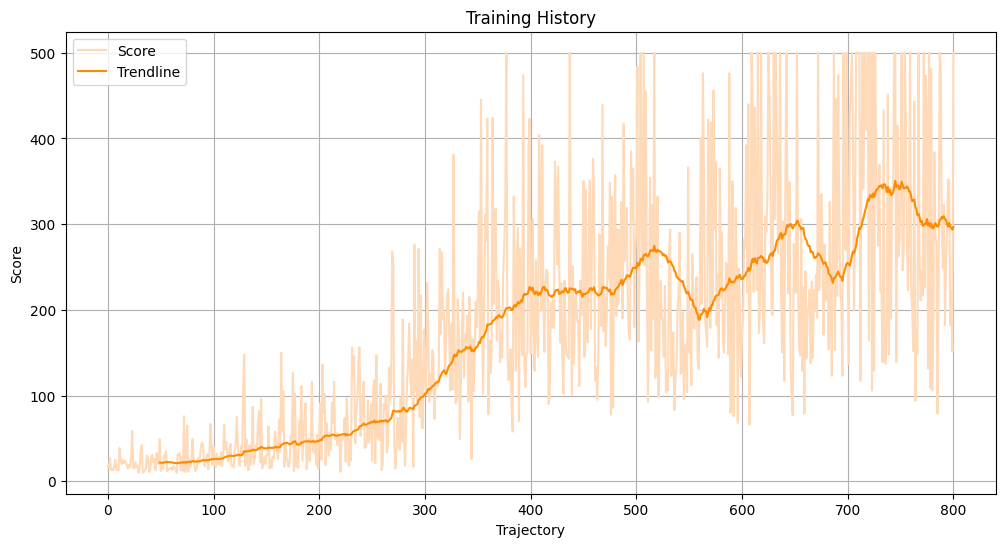

In [7]:
import matplotlib.pyplot as plt

trendline = np.convolve(reward_hist, np.ones(n_average)/n_average, mode='valid')

# plot results
plt.figure(figsize=(12, 6))
plt.plot(reward_hist, label='Score', color='#FFDAB9')
plt.plot(range(n_average-1, len(reward_hist)), trendline, label='Trendline', color='#FF8C00')
plt.title('Training History')
plt.xlabel('Trajectory')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()